In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tests.test_pixelcnn_vae import PixelCNN_VAE_Binary
from tqdm import tqdm


In [2]:
latent_dim = 100

model = PixelCNN_VAE_Binary(in_channels=1, out_channels=32, kernel_size=5, n_layers=5, latent_dim=latent_dim)
model.load_state_dict(torch.load('../pixelcnn.pt'))

<All keys matched successfully>

In [3]:
# Sample Pixel CNN
def sample(model, n_samples=1):
    # sample latent space
    z = torch.randn(n_samples, latent_dim)
#     z = torch.ones(n_samples, latent_dim)
    model.eval()
    with torch.no_grad():
        x = torch.zeros(n_samples, 1, 28, 28)
        for i in tqdm(range(28)):
            for j in range(28):
                out = model.sample(x, z)
                probs = F.softmax(out, dim=1)
                x[:, :, i, j] = torch.bernoulli(probs[:, 1, i, j]).reshape(n_samples, -1)
    return x

  0%|          | 0/28 [00:00<?, ?it/s]/gpfs/home/rrodri19/abs-mdp/venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 28/28 [00:38<00:00,  1.36s/it]


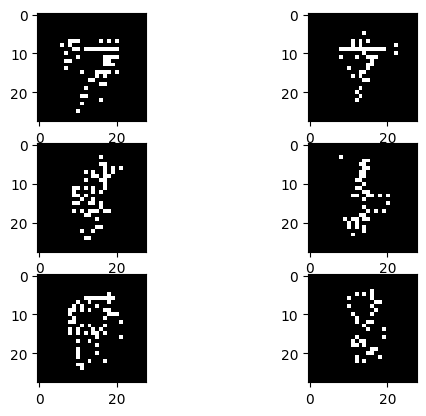

In [4]:
n_samples = 6
samples = sample(model, n_samples)


# Plot
for img in range(n_samples):
    plt.subplot(3, 2, img+1)
    plt.imshow(samples[img, 0], cmap='gray')

plt.show()

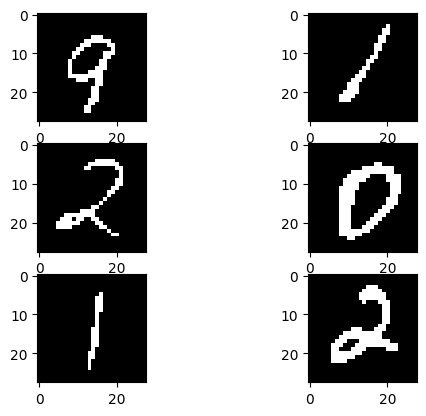

In [5]:
def binarize(img):
        # Binarize MNIST
        img =  (img > 0.7).float()
        # Plot image
        return img


# Load Binarized MNIST
transform = transforms.Compose([transforms.ToTensor(), binarize])
train_dataset = MNIST(root='data', train=True, download=True, transform=transform)
val_dataset = MNIST(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

data = iter(train_loader)
for img in range(n_samples):
    i, label = next(data)
    plt.subplot(3, 2, img+1)
    plt.imshow(i[0,0], cmap='gray')

plt.show()



In [6]:
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm

def visualize_encoded_space(model, dataset):
    model = model.float()
    
    reconstructions, zs = [], []
    for batch in tqdm(dataset):
        img, label = batch
        with torch.no_grad():
            reconstruction, z_dist, _ = model(img)
        z = z_dist.mean
        reconstructions.append(reconstruction)
        zs.append(z)
        
    z = torch.cat(zs, dim=0)
    reconstruction = torch.cat(reconstructions, dim=0)
    
#     z_embedded = TSNE(n_components=2, learning_rate='auto',
#                  init='random', perplexity=3).fit_transform(z)
    z_embedded = z
    return reconstruction, z, z_embedded


data = iter(val_loader)
reconstruction, z, z_embedded = visualize_encoded_space(model, data)
    

100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


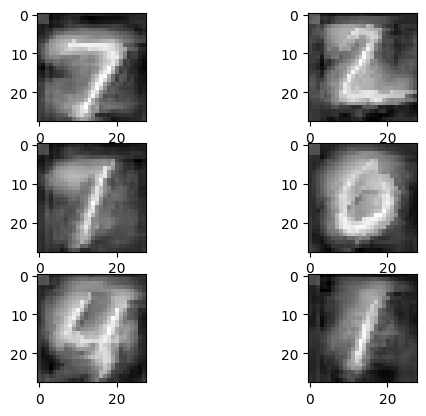

In [7]:
for img in range(n_samples):
    plt.subplot(3, 2, img+1)
    plt.imshow(reconstruction[img, 1], cmap='gray')

plt.show()

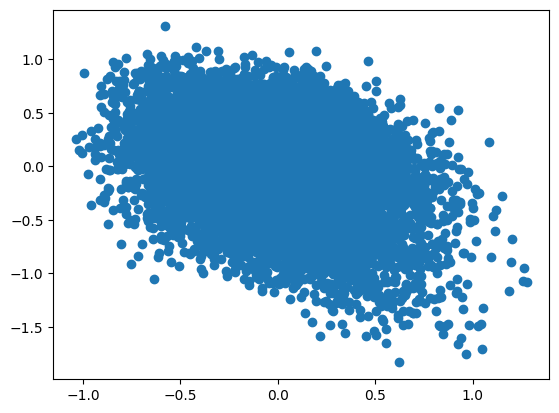

In [8]:
plt.scatter(z_embedded[:,0], z_embedded[:, 1])
plt.show()

In [9]:
average_norm = (z ** 2).sum(dim=-1).mean().sqrt()
mean = z.mean(dim=0)
std = z.std(dim=0)
print(mean, std)
print(average_norm)

tensor([ 0.0316,  0.0032, -0.0159, -0.0890,  0.0412, -0.0628,  0.0786, -0.0028,
        -0.0223, -0.0464, -0.0018,  0.0204,  0.0243, -0.0357,  0.0408, -0.0622,
        -0.0368,  0.1015,  0.0494, -0.0765,  0.0523,  0.0499, -0.0865,  0.0197,
        -0.0410, -0.0138,  0.0165,  0.0028,  0.0859,  0.0072, -0.0119,  0.0229,
         0.0223, -0.0579,  0.0148, -0.0092, -0.0599, -0.0082,  0.0836,  0.0242,
         0.0006,  0.0727,  0.0598,  0.0176,  0.0548,  0.0540,  0.0318,  0.0528,
         0.0466, -0.0182,  0.0194,  0.0257, -0.0403, -0.0488, -0.0313, -0.0383,
        -0.0499, -0.0151, -0.1093,  0.0582,  0.0836, -0.0242,  0.0671, -0.0161,
        -0.0776,  0.0322, -0.0411,  0.0544, -0.0146,  0.0175, -0.0333,  0.0166,
        -0.0163,  0.0196, -0.0201,  0.0378, -0.0192, -0.0139,  0.0402, -0.0233,
         0.0842,  0.0093,  0.0180,  0.1593, -0.1467, -0.0257, -0.1013, -0.0077,
         0.0466,  0.0239, -0.0623,  0.0675, -0.0312,  0.0861, -0.0177, -0.0728,
        -0.0164, -0.0327, -0.0300, -0.01

In [10]:
def sample_latent(model, latent, n_samples=1):
    # sample latent space
    z = latent
    model.eval()
    with torch.no_grad():
        x = torch.zeros(z.shape[0], 1, 28, 28)
        for i in tqdm(range(28)):
            for j in range(28):
                out = model.sample(x, z)
                probs = F.softmax(out, dim=1)
                x[:, :, i, j] = torch.bernoulli(probs[:, 1, i, j]).reshape(z.shape[0], -1)
    return x

100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


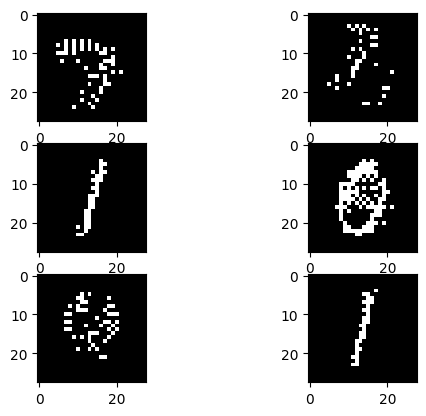

In [11]:
samples = sample_latent(model, z[:n_samples])

for img in range(n_samples):
    plt.subplot(3, 2, img+1)
    plt.imshow(samples[img, 0], cmap='gray')

plt.show()

In [12]:
from src.abstract_mdp.pixelcnn import PixelCNNDecoderBinary

model = PixelCNNDecoderBinary(10, 1, 64, 7, 5)
model.load_state_dict(torch.load('../cond_pixelcnn.pt'))

# Sample Pixel CNN
def sample(model, label, n_samples=1):
    model.eval()
    with torch.no_grad():
        x = torch.zeros(n_samples, 1, 28, 28)
        for i in tqdm(range(28)):
            for j in range(28):
                out = model(x, label)
                probs = F.softmax(out, dim=1)
                x[:, :, i, j] = torch.bernoulli(probs[:, 1, i, j]).reshape(n_samples, -1)
    return x

RuntimeError: Error(s) in loading state_dict for PixelCNNDecoderBinary:
	size mismatch for causal_block.channels_conv.conv.weight: copying a param with shape torch.Size([128, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 1, 1, 1]).
	size mismatch for stack.layers.0.channels_conv.conv.weight: copying a param with shape torch.Size([128, 64, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for stack.layers.1.channels_conv.conv.weight: copying a param with shape torch.Size([128, 64, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for stack.layers.2.channels_conv.conv.weight: copying a param with shape torch.Size([128, 64, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for stack.layers.3.channels_conv.conv.weight: copying a param with shape torch.Size([128, 64, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).

In [ ]:
# Sample 4 images
samples = sample(model, torch.Tensor([4,5,2,0]).long(), 4)


print(torch.max(samples))
# Plot
for img in range(4):
    plt.subplot(2, 2, img+1)
    plt.imshow(samples[img, 0], cmap='gray')

plt.show()